# Initialize

In [20]:
from pytorch_grad_cam import GradCAM
import torch
from PIL import Image
import numpy as np
import cv2
import os
import open_clip

from tqdm import tqdm
from pytorch_grad_cam.utils.image import scale_cam_image
from utils import parse_xml_to_dict, scoremap2bbox
from clip_text import class_names#, imagenet_templates
import argparse
from torch import multiprocessing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip

import types
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
import warnings
warnings.filterwarnings("ignore")

# Help functions

In [21]:
# -*- coding:UTF-8 -*-
from pytorch_grad_cam import GradCAM
import torch
from PIL import Image
import numpy as np
import cv2
import os
import open_clip

from tqdm import tqdm
from pytorch_grad_cam.utils.image import scale_cam_image
from utils import parse_xml_to_dict, scoremap2bbox
from clip_text import class_names#, imagenet_templates
import argparse
from torch import multiprocessing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomHorizontalFlip

import types
import sys
sys.path.insert(0, '/home/zhang.13617/Desktop/BioCLIP_visualize')
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
import warnings
warnings.filterwarnings("ignore")

def reshape_transform(tensor, height=None, width=None):
    tensor = tensor.permute(1, 0, 2)  # Shape: (batch_size, seq_len, hidden_dim)
    seq_len = tensor.size(1)
    batch_size = tensor.size(0)
    hidden_dim = tensor.size(2)
    n_tokens = seq_len - 1  # Exclude the first token (e.g., [CLS] token)

    if height is not None and width is not None:
        if height * width != n_tokens:
            raise ValueError(f"Provided height ({height}) and width ({width}) do not multiply to n_tokens ({n_tokens})")
    elif height is not None:
        if n_tokens % height != 0:
            raise ValueError(f"Cannot reshape: n_tokens ({n_tokens}) is not divisible by provided height ({height})")
        width = n_tokens // height
    elif width is not None:
        if n_tokens % width != 0:
            raise ValueError(f"Cannot reshape: n_tokens ({n_tokens}) is not divisible by provided width ({width})")
        height = n_tokens // width
    else:
        # Automatically determine height and width
        height = int(n_tokens ** 0.5)
        while n_tokens % height != 0 and height > 1:
            height -= 1
        if height == 1 and n_tokens % height != 0:
            raise ValueError(f"Cannot automatically determine height and width for n_tokens ({n_tokens})")
        width = n_tokens // height

    result = tensor[:, 1:, :].reshape(batch_size, height, width, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # Shape: (batch_size, hidden_dim, height, width)
    return result



def zeroshot_classifier(classnames, templates, model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = tokenizer(texts).to(device) #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights.t()

class ClipOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform_resize(h, w):
    return Compose([
        Resize((h,w), interpolation=BICUBIC),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def img_ms_and_flip(img_path, ori_height, ori_width, scales=[1.0], patch_size=16):
    all_imgs = []
    for scale in scales:
        preprocess = _transform_resize(int(np.ceil(scale * int(ori_height) / patch_size) * patch_size), int(np.ceil(scale * int(ori_width) / patch_size) * patch_size))
        image = preprocess(Image.open(img_path))
        image_ori = image
        image_flip = torch.flip(image, [-1])
        all_imgs.append(image_ori)
        all_imgs.append(image_flip)
    return 




def adjust_image_size(h, w, n_tokens, patch_size):
    import math
    
    
    aspect_ratio = w / h
    
    h_patches = int(round(math.sqrt(n_tokens / aspect_ratio)))
    h_patches = max(h_patches, 1)  
    w_patches = n_tokens // h_patches
    
    while h_patches * w_patches != n_tokens:
        if h_patches * w_patches < n_tokens:
            w_patches += 1
        else:
            h_patches -= 1

    
    adjusted_height = h_patches * patch_size
    adjusted_width = w_patches * patch_size
    
    return adjusted_height, adjusted_width

In [22]:
def img_ms_and_flip(img_path, ori_height, ori_width, scales=[1.0], patch_size=16):
    all_imgs = []
    for scale in scales:

        adjusted_height, adjusted_width = adjust_image_size(
            ori_width, ori_height, 660, patch_size=16
        )
        image = _transform_resize(adjusted_height, adjusted_width)(
         Image.open(img_path)
        )
        image_ori = image
        image_flip = torch.flip(image, [-1])
        all_imgs.append(image_ori)
        all_imgs.append(image_flip)
    return all_imgs

# Perfrom 

In [23]:
def perform(dataset_list, args, model, fg_text_features, cam):
    device_id = "cuda:0"
    device = torch.device(device_id)
    model = model.to(device)
    fg_text_features = fg_text_features.to(device)

    os.makedirs(args.cam_out_dir, exist_ok=True)

    for im_idx, img_path in enumerate(tqdm(dataset_list)):
        image_filename = os.path.basename(img_path)
        image = Image.open(img_path).convert("RGB")
        ori_width, ori_height = image.size



        ms_imgs = img_ms_and_flip(img_path, ori_height, ori_width, scales=[1.0])
        ms_imgs = [ms_imgs[0]]

        for aug_idx, img_tensor in enumerate(ms_imgs):
            img_tensor = img_tensor.unsqueeze(0).to(device)

            h, w = img_tensor.shape[-2], img_tensor.shape[-1]

            image_features, attn_weight_list = model.encode_image(img_tensor, h, w)

            input_tensor = [image_features, fg_text_features, h, w]

            targets = None

            grayscale_cam, logits_per_image, attn_weight_last = cam(
                input_tensor=input_tensor, targets=targets, target_size=None
            )
            grayscale_cam = grayscale_cam[0, :]  # Shape: [H, W]

            grayscale_cam_highres = cv2.resize(grayscale_cam, (ori_width, ori_height))
            highres_cam = torch.tensor(grayscale_cam_highres)

            output_filename = image_filename.replace("jpg", "npy")

            np.save(
                os.path.join(args.cam_out_dir, output_filename),
                {
                    "highres_cam": grayscale_cam_highres.astype(np.float32),
                },
            )
   

In [24]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--split_file', type=str, default='/home/zhang.13617/Desktop/datas/red_winged_black/l.txt')
    parser.add_argument('--cam_out_dir', type=str, default='/home/zhang.13617/Desktop/BioCLIP_visualize/cams')
    args, unknown = parser.parse_known_args()  

    device = "cuda:0"

    txt_emb_npy = "/home/zhang.13617/Desktop/datas/txt_emb_species.npy"
    fg_text_features = torch.from_numpy(np.load(txt_emb_npy, mmap_mode="r")).to(device)
    fg_text_features = fg_text_features.t()



    print(device)
    with open(args.split_file, 'r') as file:
        train_list = [line.strip() for line in file] 
    train_list = [line.strip() for line in train_list]
    model, preprocess, _ = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
    model = model.to(device)
    
    tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

    #fg_text_features = zeroshot_classifier(class_names, ['a clean origami {}.'], model)

    target_layers = [model.visual.transformer.resblocks[-1].ln_1]
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    perform(train_list, args, model, fg_text_features, cam)


cuda:0


 11%|█         | 1/9 [00:00<00:01,  6.50it/s]

target_cate is 
[70520]
loss is 
tensor(32.4801, device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 2/9 [00:00<00:01,  4.48it/s]

target_cate is 
[368783]
loss is 
tensor(30.4969, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 3/9 [00:00<00:02,  2.87it/s]

target_cate is 
[368783]
loss is 
tensor(31.3628, device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 4/9 [00:01<00:01,  2.67it/s]

target_cate is 
[368783]
loss is 
tensor(31.4413, device='cuda:0', grad_fn=<AddBackward0>)
target_cate is 
[71416]


 67%|██████▋   | 6/9 [00:01<00:00,  4.33it/s]

loss is 
tensor(30.4425, device='cuda:0', grad_fn=<AddBackward0>)
target_cate is 
[349279]
loss is 
tensor(30.2446, device='cuda:0', grad_fn=<AddBackward0>)
target_cate is 
[349279]
loss is 
tensor(31.8274, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████▉ | 8/9 [00:02<00:00,  3.14it/s]

target_cate is 
[65872]
loss is 
tensor(31.6953, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

target_cate is 
[337890]
loss is 
tensor(32.4676, device='cuda:0', grad_fn=<AddBackward0>)


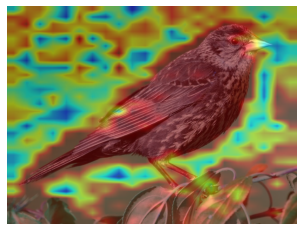

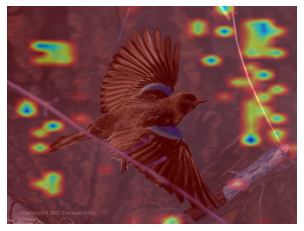

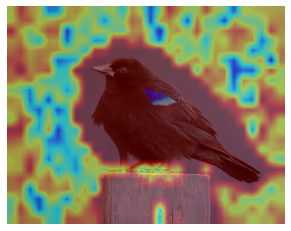

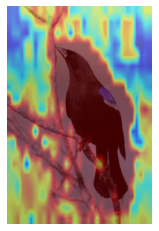

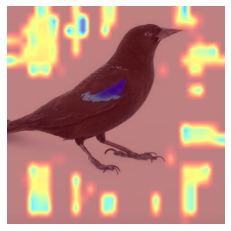

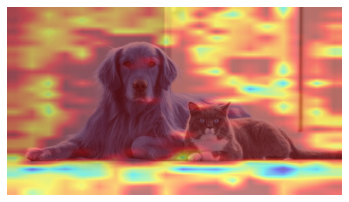

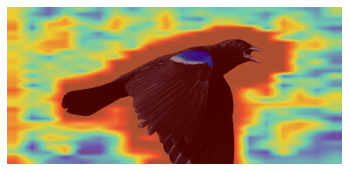

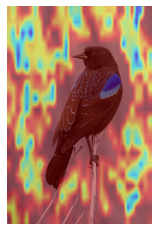

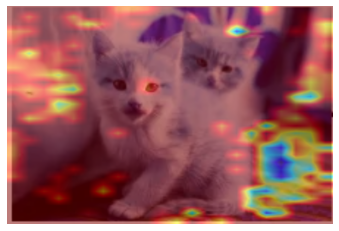

In [26]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_cam_on_image(img, cam, output_path=None):
    # Normalize CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Convert cam to uint8 type, range [0, 255]
    cam = np.uint8(255 * cam)

    # Create heatmap
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Ensure heatmap and img have the same size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Display overlay image
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Save overlay image if output_path is provided
    if output_path:
        # Convert overlay back to BGR before saving to ensure correct color order
        cv2.imwrite(output_path, overlay)

def main(cam_npy_path, img_path, output_path=None):
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to read image {img_path}")
        return

    # Read CAM data
    try:
        cam_data = np.load(cam_npy_path, allow_pickle=True).item()
    except Exception as e:
        print(f"Error loading CAM npy file: {cam_npy_path}, error: {e}")
        return

    # Check if 'highres_cam' exists in the loaded npy data
    if "highres_cam" not in cam_data:
        print(f"Error: 'highres_cam' not found in {cam_npy_path}")
        return

    cam = cam_data.get("highres_cam")  # Get 'highres_cam' from npy file

    # Ensure 'cam' is valid
    if cam is None:
        print(f"Error: 'highres_cam' is None in {cam_npy_path}")
        return

    # If cam is a 3D array (multiple heatmaps), process each one
    if cam.ndim == 3:
        for idx in range(cam.shape[0]):
            cam_single = cam[idx]
            # Adjust output filename to include index
            output_path_idx = output_path.replace('.jpg', f'_{idx}.jpg')
            visualize_cam_on_image(img, cam_single, output_path_idx)
    else:
        visualize_cam_on_image(img, cam, output_path)

if __name__ == "__main__":
    cam_npy_dir = "/home/zhang.13617/Desktop/BioCLIP_visualize/cams"
    train_absolute_txt = "/home/zhang.13617/Desktop/datas/red_winged_black/l.txt"
    output_dir = "/home/zhang.13617/Desktop/BioCLIP_visualize/cams"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get paths to .npy files sorted by filename
    cam_npy_paths = sorted([os.path.join(cam_npy_dir, f) for f in os.listdir(cam_npy_dir) if f.endswith('.npy')])

    # Read image absolute paths from train_absolute.txt
    with open(train_absolute_txt, 'r') as f:
        img_paths = [line.strip() for line in f.readlines()]

    # Iterate over CAM npy paths (process only available CAM files)
    for cam_npy_path in cam_npy_paths:
        # Try to find the corresponding image in img_paths by matching the base filename
        cam_filename = os.path.basename(cam_npy_path).replace('.npy', '')
        matching_img_paths = [img_path for img_path in img_paths if cam_filename in os.path.basename(img_path)]

        if not matching_img_paths:
            print(f"No matching image found for CAM file: {cam_npy_path}")
            continue

        # Use the first matching image path
        img_path = matching_img_paths[0]
        base_name = os.path.basename(img_path).replace('.jpg', '')

        # Generate output path
        output_filename = base_name + f'_output.jpg'
        output_path = os.path.join(output_dir, output_filename)

        # Call main function to visualize CAM on image
        main(cam_npy_path, img_path, output_path)
    